In [1]:
## Importing the required python libraries 
import os, sys
import warnings
import timeit
import numpy as np
import pandas as pd 
import pkg_resources
import matplotlib.pyplot as plt
import re
import seaborn as sns
from collections import defaultdict


In [2]:
## Importing pergene files 

pergene_files=[]
#data_dir= "../satay/data_files/data_unmerged/"
#data_dir="../transposonmapper/data_files/files4test/"
data_dir="../postprocessed-data/"
#data_dir="../transposonmapper/data_files/"
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith("pergene_insertions.xlsx"):
            pergene_files.append(os.path.join(root, file))

list_data=[]
for i in pergene_files:
    list_data.append(pd.read_excel(i,engine='openpyxl',index_col="Unnamed: 0"))

keys=[]
for i in np.arange(0,len(pergene_files)):
    keys.append(pergene_files[i].split("/")[-1].split("_")[0]+"_"+pergene_files[i].split("/")[-1].split("_")[1])

list_data_pd=pd.concat(list_data,axis=0,keys=keys)

In [3]:
## Importing postproccesed data from pipeline
from ast import literal_eval
data_post=[]

for i in keys:
    data_post.append(pd.read_excel(data_dir+i+".xlsx",index_col="Unnamed: 0",engine='openpyxl'))
    
list_data_post=pd.concat(data_post,axis=0,keys=keys)
list_data_post.drop(columns=["Feature_alias","Feature_name"],inplace=True)
list_data_post.fillna(1,inplace=True)


In [4]:
list_data_post.groupby("Feature_type").count()

,Standard_name,Essentiality,Chromosome,Position,Nbasepairs,Ninsertions,Ninsertions_truncatedgene,Nreads,Nreads_list,Nreads_truncatedgene,Nreadsperinsrt,Nreadsperinsrt_truncatedgene
Feature_type,,,,,,,,,,,,
1,80787,80787,80787,80787,80787,80787,80787,80787,80787,80787,80787,80787
ARS,5070,5070,5070,5070,5070,5070,5070,5070,5070,5070,5070,5070
Centromere,225,225,225,225,225,225,225,225,225,225,225,225
Gene; Dubious,6735,6735,6735,6735,6735,6735,6735,6735,6735,6735,6735,6735
Gene; Uncharacterized,8475,8475,8475,8475,8475,8475,8475,8475,8475,8475,8475,8475
Gene; Verified,74703,74703,74703,74703,74703,74703,74703,74703,74703,74703,74703,74703
Gene; Verified|silenced_gene,60,60,60,60,60,60,60,60,60,60,60,60
Intron,465,465,465,465,465,465,465,465,465,465,465,465
Noncoding_exon,5415,5415,5415,5415,5415,5415,5415,5415,5415,5415,5415,5415


In [5]:
#list_data_post.to_excel("../postprocessed-data/postprocessed_data_all_backgrounds.xlsx")

In [6]:
## Importing gene protein length , and protein domains coordinates of every gene 

protein_length=pd.read_csv('../data/Gene_Protein_length_yeastmine.tsv',sep="\t")
protein_length.index=protein_length.loc[:,"Gene Name"]
protein_length.drop(columns="Gene Name",inplace=True)

domains_coordinates=pd.read_csv('../data/Domains_all_genes_protein_coordinates_yeastmine.tsv',sep="\t")

domains_coordinates.dropna(inplace=True)
gene_with_introns=pd.read_csv('../data/Gene_Introns.tsv',sep="\t")



In [7]:
## Combine protein length and protein domains coordinates
domains_coordinates.loc[:,"Protein Length"]=np.nan
for gene_name in protein_length.index: 
    tmp=np.where(domains_coordinates.loc[:,"Gene Name"]==gene_name)[0]
    if tmp.size!=0: 
        for i in np.arange(0,len(tmp)):
            domains_coordinates.loc[tmp[i], "Protein Length"]=protein_length.loc[gene_name, "Protein Length"]

domains_coordinates.dropna(inplace=True) # to drop the proteins that do not have protein domains annotated
domains_coordinates.index=domains_coordinates.loc[:,"Gene Name"]
domains_coordinates.drop(columns="Gene Name",inplace=True)

In [8]:
domains_coordinates.head(2)

,Protein Domain,Protein domain description,Protein start location,Protein End location,Method,Domain ID,Protein Length
Gene Name,,,,,,,
AAC1,PF00153,Mitochondrial carrier protein; Mitochondrial s...,10,106,Pfam,2106639,309.0
AAC1,PF00153,Mitochondrial carrier protein; Mitochondrial s...,116,210,Pfam,2106640,309.0


In [9]:

## make a dictionary with protein domains locations per gene , the solution of an array and attaching it
# a dataframe do not work, so I will use a dictionary

list_data_domains_data=list_data_pd.copy()
df=list_data_domains_data.loc["wt_merged"] # as dataset to take info about proteins 
df.set_index("Gene name",inplace=True)

domain_locations=defaultdict(dict)

for j in df.index:
    if j in domains_coordinates.index:
        if len([domains_coordinates.loc[j,"Protein Domain"]])>1:
            for i in np.arange(0,len(domains_coordinates.loc[j,"Protein Domain"].tolist())):
            
                domain_locations[j][i]=(np.array([domains_coordinates.loc[j,"Protein start location"][i],domains_coordinates.loc[j,
        "Protein End location"][i]]))
        else:
            domain_locations[j]=(np.array([domains_coordinates.loc[j,"Protein start location"],domains_coordinates.loc[j,
    "Protein End location"]]))
    else:
        domain_locations[j]=np.nan


domains_names=defaultdict(dict)


for j in df.index:
    if j in domains_coordinates.index:
        if type(domains_coordinates.loc[j,"Protein Domain"])!=str:
            if len(domains_coordinates.loc[j,"Protein Domain"].tolist())>1:
                for i in np.arange(0,len(domains_coordinates.loc[j,"Protein Domain"].tolist())):
                    domains_names[j][i]=np.array(domains_coordinates.loc[j,"Protein Domain"][i])
            else:
                domains_names[j]=np.array(domains_coordinates.loc[j,"Protein Domain"])
        else:
            domains_names[j]=np.array(domains_coordinates.loc[j,"Protein Domain"])
    else:
        domains_names[j]=np.nan
        


# for i in df.index:
#     if i in domains_coordinates.index:
#         df.loc[i,"protein length"]=np.unique(domains_coordinates.loc[i,"Protein Length"]).tolist()

#     else:
#         df.loc[i,"protein length"]=np.nan

protein_length_dict=defaultdict(dict)

for i in df.index:
    if i in domains_coordinates.index:
        protein_length_dict[i]=np.unique(domains_coordinates.loc[i,"Protein Length"]).tolist()
    else:
        protein_length_dict[i]=np.nan


In [10]:
domains_names_df=pd.DataFrame.from_dict(domains_names,orient="index")
domains_names_df.columns=["protein domain"]

domain_locations_df=pd.DataFrame.from_dict(domain_locations,orient="index")
domain_locations_df.columns=["domain locations"]

protein_length_dict_df=pd.DataFrame.from_dict(protein_length_dict,orient="index")

protein_length_dict_df.columns=["protein length"]

In [11]:
# Merge this info with all the keys from the different backgrounds
list_data_pd_merged=[]
for key in keys:
    df=list_data_pd.loc[key]
    df.set_index("Gene name",inplace=True)
    tmp=pd.merge(df,domain_locations_df,left_index=True,right_index=True)
    tmp_I=pd.merge(tmp,domains_names_df,left_index=True,right_index=True)
    tmp_II=pd.merge(tmp_I,protein_length_dict_df,left_index=True,right_index=True)
    list_data_pd_merged.append(tmp_II)



In [12]:
list_data_pd_merged_pd=pd.concat(list_data_pd_merged,keys=keys)

# saving information into an excel sheet to reuse 

#list_data_pd_merged_pd.to_excel("../postprocessed-data/merged-data-with-domains-info.xlsx")


In [13]:
a=list_data_pd_merged_pd.loc["wt_merged"]

a.loc["FLO9"]

Chromosome                                                                      I
Start location                                                              24000
End location                                                                27968
Insertion locations             [24010, 24018, 24036, 24037, 24050, 24051, 240...
Reads per insertion location    [33, 32, 22, 10, 94, 19, 55, 124, 32, 119, 26,...
Reads                                                                       13336
Insertions                                                                    198
domain locations                [[276, 322, 367, 413, 458, 503, 548, 592, 637,...
protein domain                  {0: PF00624, 1: PF00624, 2: PF00624, 3: PF0062...
protein length                                                           [1322.0]
Name: FLO9, dtype: object

In [14]:
from get_reads_per_domain import get_reads_per_domain

reads_per_domain_dict=defaultdict(dict)
domain_genomics_dict=defaultdict(dict)
insertions_per_domain_dict=defaultdict(dict)

for key in keys:
    A=list_data_pd_merged_pd.loc[key]
    
    for gene in A.index:
  
        a,b,c=get_reads_per_domain(A,gene)

        reads_per_domain_dict[key,gene]=a
        domain_genomics_dict[key,gene]=b
        insertions_per_domain_dict[key,gene]=c



In [15]:

reads_per_domain_df=pd.DataFrame.from_dict(reads_per_domain_dict,orient="index")
domain_genomics_df=pd.DataFrame.from_dict(domain_genomics_dict,orient="index")
insertions_per_domain_df=pd.DataFrame.from_dict(insertions_per_domain_dict,orient="index")




#b=reads_per_domain_df.loc[[("wt_merged","BEM2")],:].dropna(axis=1)

# a=domain_genomics_df.index[0]
# gene="BEM1"
# key="wt_merged"
# gene= "BEM1"

# b=domain_genomics_df.loc[[(key,gene)],:].dropna(axis=1)

# np.array(b).tolist()[0]


# reads_per_domain_df.to_excel("../postprocessed-data/reads-per-domain-all-backgrounds.xlsx")
# domain_genomics_df.to_excel("../postprocessed-data/genetic-coordinates-domains-pfam.xlsx")

#insertions_per_domain_df.to_excel("../postprocessed-data/insertions-per-domain-all-backgrounds.xlsx")

In [16]:
keys

['dbem3_b',
 'dnrp1_b',
 'bem1-aid_a',
 'dnrp1_a',
 'dbem1dbem3_b',
 'wt_merged',
 'dbem1dbem3_a',
 'bem1-aid-dbem3_a',
 'bem1-aid-dbem3_b',
 'wt_b',
 'wt_a',
 'dnrp1_merged',
 'bem1-aid_b',
 'dbem3_merged',
 'dbem3_a']

/data/localhome/linigodelacruz/Documents/PhD_2018/Documentation/SATAY/src(source-code)/Data-analysis-multiple-strains/src/plot_reads_per_gene_with_domains.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


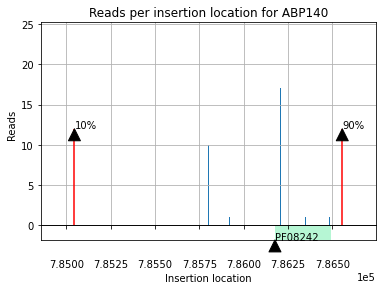

In [19]:
from plot_reads_per_gene_with_domains import plot_reads_per_gene_with_domains
gene="ABP140"
key="bem1-aid_a"
data=list_data_pd_merged_pd.loc[key]
plot_reads_per_gene_with_domains(data=data,gene=gene,domain_genomics_coordinates=domain_genomics_df,key=key)
#plt.tight_layout()
plt.savefig("../figures/fig_reads_per_gene_with_domains_" + gene + "_"+key+ ".png",dpi=300)

In [18]:
from from_excel_to_list import from_excel_to_list

data=list_data_pd_merged_pd.loc[key]
insertions_vector=from_excel_to_list(data.loc[gene,"Insertion locations"])
reads_vector=from_excel_to_list(data.loc[gene,"Reads per insertion location"])
print(insertions_vector,reads_vector)


[161139.0, 161224.0, 161269.0, 161288.0, 161305.0, 161320.0, 161348.0, 161369.0, 161382.0, 161459.0, 161490.0, 161572.0, 161683.0, 161696.0, 161705.0, 161707.0, 161716.0, 161728.0, 161734.0, 161740.0, 161755.0, 161765.0, 161766.0, 161769.0, 161773.0, 161781.0, 161785.0, 161800.0, 161803.0, 161805.0, 161814.0, 161817.0, 161820.0, 161826.0, 161832.0, 161854.0, 161857.0, 161858.0, 161859.0, 161863.0, 161869.0, 161881.0, 161919.0, 161919.0, 161920.0, 161925.0, 161969.0, 161980.0, 161992.0, 161998.0, 162005.0, 162019.0, 162031.0, 162035.0, 162077.0, 162083.0, 162086.0, 162089.0, 162096.0, 162096.0, 162101.0, 162103.0, 162115.0, 162119.0, 162123.0, 162124.0, 162128.0, 162134.0, 162178.0, 162178.0, 162179.0, 162180.0, 162182.0, 162183.0, 162186.0, 162208.0, 162215.0, 162229.0, 162234.0, 162238.0, 162247.0, 162248.0, 162258.0, 162258.0, 162264.0, 162264.0, 162266.0, 162269.0, 162270.0, 162299.0, 162309.0, 162316.0, 162339.0, 162352.0, 162355.0, 162358.0, 162371.0, 162389.0, 162414.0, 162421.0,

In [19]:
##  adding the Essentiality column to a the dataframe  ref


ref=list_data_pd_merged_pd.loc["wt_merged"]


for i in ref.index: 
    
    if i in list_data_post.loc["dbem3_b"]["Standard_name"].tolist():
        ref.loc[i,"Essentiality"]=list_data_post.loc["dbem3_b"][list_data_post.loc["dbem3_b"]["Standard_name"]==i]["Essentiality"].tolist()[0]

## adding that column to all kes in the dataframe 
for key in keys:
    A=list_data_pd_merged_pd.loc[key]
    A["Essentiality"]=ref["Essentiality"] 
    #list_data_pd_merged_pd.loc[key]=A

/data/localhome/linigodelacruz/anaconda3/envs/transposonmapper/lib/python3.9/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/tmp/ipykernel_8658/4230794356.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A["Essentiality"]=ref["Essentiality"]


In [20]:

## make a dict and then add it as a column to the dataframe

ref=list_data_pd_merged_pd.loc["wt_merged"]
maybe_essentials=defaultdict(dict)
true_essentials=defaultdict(dict)

for key in keys:
    # list_data_pd_merged_pd.loc[key]["maybe essential domain"]=np.nan
    # list_data_pd_merged_pd.loc[key]["true essential domain"]=np.nan
    for gene in ref.index:
        #print(key,gene)
        if (key,gene) in reads_per_domain_df.index:
            b=np.array(reads_per_domain_df.loc[[(key,gene)],:].dropna(axis=1)).tolist()[0]
            tmp=np.where(np.array(b)==0)[0]
            #print(tmp)
            if len(tmp)>0: # if there  zero reads in some domain
                
                maybe_essentials[key,gene]=1
                
                for i in [tmp]:
                    
                    if (i+1).tolist()[0]< len(b) and 0<(i-1).tolist()[0]<len(b):
                        if b[(tmp+1).tolist()[0]]>30 or b[(tmp-1).tolist()[0]]>30: # the surroundings of zero reads are not zero
                            
                            true_essentials[key,gene]=1
                        else:
                            true_essentials[key,gene]=0
                    else:
                        true_essentials[key,gene]=0

            else:
                
                maybe_essentials[key,gene]=0
               
                true_essentials[key,gene]=0
 

        




In [21]:
## all domains from all backgrounds and its classifications



maybe_essentials_df=pd.DataFrame.from_dict(maybe_essentials,orient="index")

maybe_essentials_df.columns=["maybe essentials domains"]

true_essentials_df=pd.DataFrame.from_dict(true_essentials,orient="index")

true_essentials_df.columns=["true essentials domains"]




In [22]:
## taking the essential domains from the WT_merged dataset
#essentials_wt=list_data_pd_merged_pd.loc["wt_merged"]["Essentiality"].tolist()
essentials_wt=ref["Essentiality"].tolist()

# append the true essentials gene from the proteins domains 
essentials_domains=[] 
essentials_domains_stringent=[]
for gene in list_data_pd_merged_pd.loc["wt_merged"].index:
    essentials_domains.append(np.array(maybe_essentials_df.loc[[("wt_merged",gene)],:])[0][0])
    essentials_domains_stringent.append(np.array(true_essentials_df.loc[[("wt_merged",gene)],:])[0][0])



KeyError: 'Essentiality'

In [ ]:

print("The number of essential protein domains in WT is =",len(essentials_wt)-len(np.where(np.array(essentials_domains)==0)[0]))
print("The number of known essential genes in WT is =",len(essentials_wt)-len(np.where(np.array(essentials_wt)==0)[0]))
print("The number of known essentials that have also an essential domain is = ",
len(np.intersect1d(np.where(np.array(essentials_wt)==1)[0],np.where(np.array(essentials_domains)==1)[0])))

print("The number of stringent essential protein domains in WT is =",len(essentials_wt)-len(np.where(np.array(essentials_domains_stringent)==0)[0]))
print("The number of known essential genes in WT is =",len(essentials_wt)-len(np.where(np.array(essentials_wt)==0)[0]))
print("The number of known essentials that have also a stringent essential domain is = ",
len(np.intersect1d(np.where(np.array(essentials_wt)==1)[0],np.where(np.array(essentials_domains_stringent)==1)[0])))



The number of essential protein domains in WT is = 397
The number of known essential genes in WT is = 1872
The number of known essentials that have also an essential domain is =  102
The number of stringent essential protein domains in WT is = 30
The number of known essential genes in WT is = 1872
The number of known essentials that have also a stringent essential domain is =  13


In [ ]:
## save the print statetments into a file 

import sys

orig_stdout = sys.stdout
f = open('../figures/essential_wt_domains_summary.txt', 'w')
sys.stdout = f

print("The number of essential protein domains in WT is =",len(essentials_wt)-len(np.where(np.array(essentials_domains)==0)[0]))
print("The number of known essential genes in WT is =",len(essentials_wt)-len(np.where(np.array(essentials_wt)==0)[0]))
print("The number of known essentials that have also an essential domain is = ",
len(np.intersect1d(np.where(np.array(essentials_wt)==1)[0],np.where(np.array(essentials_domains)==1)[0])))

print("The number of stringent essential protein domains in WT is =",len(essentials_wt)-len(np.where(np.array(essentials_domains_stringent)==0)[0]))
print("The number of known essential genes in WT is =",len(essentials_wt)-len(np.where(np.array(essentials_wt)==0)[0]))
print("The number of known essentials that have also a stringent essential domain is = ",
len(np.intersect1d(np.where(np.array(essentials_wt)==1)[0],np.where(np.array(essentials_domains_stringent)==1)[0])))



sys.stdout = orig_stdout
f.close()

<AxesSubplot:>

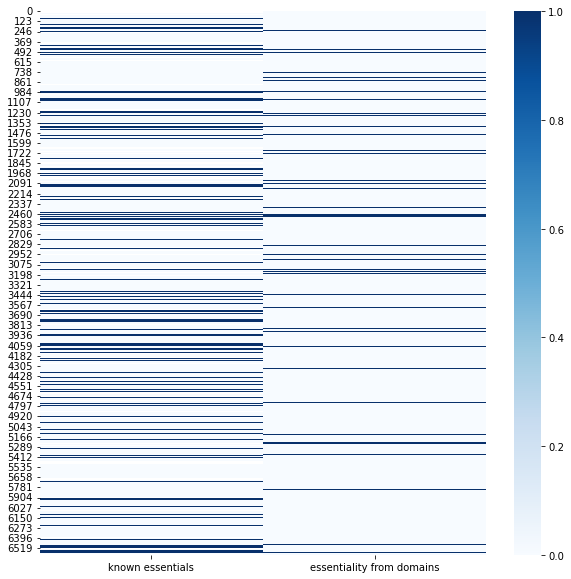

In [ ]:
a=[essentials_wt,essentials_domains]

a_df=pd.DataFrame(a).T
a_df.columns=["known essentials","essentiality from domains"]

plt.figure(figsize=(10,10))
sns.heatmap(a_df,cmap="Blues")
#plt.savefig("../figures/fig_heatmap_known_esentials_vs_essentiality_from_domains_wt.png",dpi=300)


[(0.0, 150.0)]

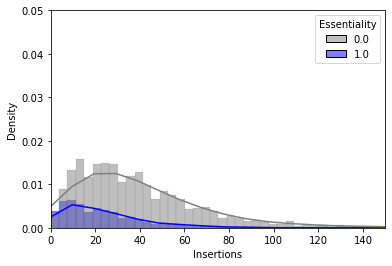

In [ ]:
stat="density"
g=sns.histplot(data=ref,x="Insertions",hue="Essentiality",kde=True,
palette=["gray","blue"],stat=stat)
g.set(ylim=(0, 0.05))
g.set(xlim=(0, 150))
#plt.savefig("../figures/fig_hist_"+stat+"_insertions_per_gene_essentiality_wt.png",dpi=300)

In [ ]:
20/1884

0.010615711252653927